# Fraud Detection using Support Vector Machine (SVM) 

---

### Related Works and Research Papers

#### References:
1. **Batista, G. E., Prati, R. C., & Monard, M. C. (2004)** – "A study of the behavior of several methods for balancing machine learning training data." *ACM SIGKDD explorations newsletter*, 6(1), 20-29.  
   DOI: [10.1007/978-3-540-30115-8_7](https://link.springer.com/chapter/10.1007/978-3-540-30115-8_7)

2. **Nagi, J., Yap, K. S., Tiong, S. K., Ahmed, S. K., & Mohamad, M. (2010)** – "Nontechnical Loss Detection for Metered Customers in Power Utility Using Support Vector Machines" *IEEE Transactions on Power Delivery*, vol. 25, no. 2, pp. 1162‑1171, Apr. 2010.  
   DOI: [10.1109/TPWRD.2009.2030890](https://ieeexplore.ieee.org/document/5286297)

3. **Prabhat Kumar (2021)** – "Credit Card Fraud Detection Using Support Vector Machines".
   Sourced from: https://github.com/prabhatk579/credit-card-fraud-detection-using-support-vector-machine/tree/main 

#### Limitations Identified in the Studies
- Class imbalance causes SVM to be biased toward the majority (non-fraud) class, especially with linear kernels.
- SVM requires careful hyperparameter tuning (C, kernel, gamma) for optimal performance.
- Standard accuracy metrics can be misleading for imbalanced datasets - need PR-AUC alongside ROC-AUC.

#### Our Approach to Overcome These Limitations
- Applied **SMOTE** only on training data to safely rebalance the dataset without leakage.
- Used **Optuna** for automated hyperparameter tuning with Tree-structured Parzen Estimator (TPE) sampler.
- Introduced **PR-AUC** metric alongside ROC-AUC for more realistic evaluation on rare fraud cases.
- Tested multiple SVM kernels (Linear, RBF, Poly, Sigmoid) with both with/without SMOTE approaches.
- Compared baseline and tuned models fairly under identical data splits with stratified 5-fold CV.

---

### Machine Learning Algorithm Details

- **Algorithms Used:**  
  - Support Vector Machine (LinearSVC and SVC with multiple kernels)
  - Optuna (Bayesian optimization for hyperparameter tuning)
  - SMOTE (Synthetic Minority Oversampling Technique)

- **Why These Algorithms Are Appropriate:**  
  SVM provides robust classification with strong theoretical foundations and performs well with high-dimensional data. SMOTE handles imbalanced data by generating synthetic minority samples. Optuna improves tuning efficiency via sequential model-based optimization.

- **Original Contributions:**  
  - Comprehensive comparison of LinearSVC vs multiple SVC kernels under identical settings.
  - Systematic evaluation with/without SMOTE across all kernel types.
  - Dual metric evaluation (ROC-AUC and PR-AUC) for fraud-specific performance assessment.
  - Cost-sensitive learning with class_weight parameter tuning.

---

### Experiments and Results

- **Multiple Models Implemented:**  
  - LinearSVC without SMOTE (Optuna-tuned)
  - LinearSVC with SMOTE (Optuna-tuned)
  - RBF SVC (Optuna-tuned)

- **Training, Cross-Validation, and Testing:**  
  Each model trained with 5-Fold stratified CV and tested on unseen test data.  
  Evaluations conducted using metrics:
  - ROC-AUC  
  - PR-AUC (Precision-Recall AUC)
  - Precision, Recall, Accuracy and F1-score for class "1" (fraud)

- **Comparisons and Findings:**  
  Results will show which combination of kernel + SMOTE provides the best fraud detection performance.

---

### Attribution and Reproducibility

- Code templates for Optuna and SMOTE were adapted from:
  - [Optuna official documentation](https://optuna.org/)
  - [Imbalanced-learn documentation](https://imbalanced-learn.org/stable/)
  - [Scikit-learn SVM examples](https://scikit-learn.org/stable/modules/svm.html)
- All visualizations and comparison functions were written by our team.
- Random seeds fixed (`random_state=1244`) for consistent reproducibility.

---

## Support Vector Machine Models

We will implement and compare:
1. LinearSVC without SMOTE (Baseline with Optuna)
2. LinearSVC with SMOTE (Optuna)
3. SVC (RBF kernel) without SMOTE
4. SVC (RBF kernel) with SMOTE

In [1]:
import joblib 
import category_encoders as ce
from category_encoders import TargetEncoder
import numpy as np
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC 
import warnings
import optuna
from optuna.samplers import TPESampler

X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')
X_test = joblib.load('../data/X_test.pkl')
y_test = joblib.load('../data/y_test.pkl')

c:\Users\User\OneDrive - National University of Singapore\IT1244\src\venv-it1244\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
target_encoder = joblib.load('../data/target_encoder.pkl')
one_hot_encoder = joblib.load('../data/one_hot_encoder.pkl')

In [3]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("\nData types:")
print(X_train.dtypes)
print("\nClass distribution:")
print(y_train.value_counts())

X_train shape: (9392, 32)
X_test shape: (2349, 32)

Data types:
region                         category
dis                            category
catg                           category
mean_consommation_level_1       float64
median_consommation_level_1     float64
std_consommation_level_1        float64
min_consommation_level_1          int64
max_consommation_level_1          int64
sum_consommation_level_1          int64
std_consommation_level_3        float64
max_consommation_level_3          int64
sum_consommation_level_3          int64
mean_consommation_level_4       float64
std_consommation_level_4        float64
max_consommation_level_4          int64
sum_consommation_level_4          int64
sum_counter_coefficient           int64
mode_tarif_type                category
nunique_counter_statue            int64
mode_reading_remarque          category
nunique_reading_remarque          int64
num_invoices                      int64
active_days                       int64
consumption_mean

### Notes on Class Imbalance
The dataset exhibits significant class imbalance (fraud cases < 5% of total observations).
This imbalance affects model performance and requires specialized handling techniques.
Multiple approaches are compared to evaluate their effectiveness in addressing this challenge.

### Preprocessing
- **Numeric features**: StandardScaler for normalization
- **Categorical features**: One-Hot Encoding

In [4]:
# Transform using saved encoders (no fitting needed)
X_train = target_encoder.transform(X_train)
X_test = target_encoder.transform(X_test)

X_train = one_hot_encoder.transform(X_train)
X_test = one_hot_encoder.transform(X_test)

In [5]:
# Helper function for SMOTE resampling
def apply_smote(X: pd.DataFrame, y: pd.Series, random_state: int = 1244):
    """
    Apply SMOTE to resample the dataset.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target variable
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X_resampled : pd.DataFrame
        Resampled feature matrix
    y_resampled : pd.Series
        Resampled target variable
    """
    sm = SMOTE(random_state=random_state)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    return X_resampled, y_resampled

In [6]:
# Containers for cross-model reporting
model_results_summary = []
roc_curve_data = []
model_artifacts = {}


## Model 1: LinearSVC without SMOTE (Optuna Tuning)

Hyperparameter (C) optimization using Optuna with 5-fold stratified cross-validation.

In [7]:
def preprocess_fold(X_fold, y_fold=None, scaler=None, fit=True):
    if fit:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_fold) 
        return X_scaled, scaler
    else:
        X_scaled = scaler.transform(X_fold) 
        return X_scaled, scaler

In [8]:
def objective(trial):
    """Objective function for Optuna hyperparameter optimization."""
    C = trial.suggest_float('C', 0.1, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1244)
    auc_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        X_tr_scaled, scaler = preprocess_fold(X_tr, y_tr, fit=True)
        X_val_scaled, _ = preprocess_fold(X_val, scaler=scaler, fit=False)

        svm = LinearSVC(
            C=C,
            class_weight=class_weight,
            random_state=1244,
            max_iter=2000,
            dual='auto' 
        )
        svm.fit(X_tr_scaled, y_tr)

        decision = svm.decision_function(X_val_scaled)
        auc_scores.append(roc_auc_score(y_val, decision))

    return np.mean(auc_scores)

In [9]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1244)   
)

study.optimize(objective, n_trials=30, show_progress_bar=True)

Best trial: 11. Best value: 0.750764: 100%|██████████| 30/30 [02:54<00:00,  5.83s/it]


## Best Model Results

In [10]:
# Finalize Model 1 (LinearSVC without SMOTE) and prepare evaluation artifacts
best_params = study.best_params

scaler_m1 = StandardScaler()
X_train_m1 = scaler_m1.fit_transform(X_train)
X_test_m1 = scaler_m1.transform(X_test)

model1_clf = LinearSVC(
    C=best_params['C'],
    class_weight=best_params['class_weight'],
    random_state=1244,
    max_iter=2000,
    dual='auto'
)
model1_clf.fit(X_train_m1, y_train)

model1_scores = model1_clf.decision_function(X_test_m1)
model1_pred = model1_clf.predict(X_test_m1)
model1_accuracy = accuracy_score(y_test, model1_pred)
model1_confusion = confusion_matrix(y_test, model1_pred)

report_m1 = classification_report(
    y_test,
    model1_pred,
    target_names=['Non-Fraud', 'Fraud'],
    output_dict=True,
    digits=4
)
roc_auc_m1 = roc_auc_score(y_test, model1_scores)
pr_auc_m1 = average_precision_score(y_test, model1_scores)

model1_metrics = {
    'Model': 'LinearSVC (No SMOTE)',
    'ROC-AUC': roc_auc_m1,
    'PR-AUC': pr_auc_m1,
    'Accuracy': model1_accuracy,
    'Precision (Fraud)': report_m1['Fraud']['precision'],
    'Recall (Fraud)': report_m1['Fraud']['recall'],
    'F1-Score (Fraud)': report_m1['Fraud']['f1-score']
}

# Refresh stored summaries for idempotent re-runs
model_results_summary = [m for m in model_results_summary if m['Model'] != model1_metrics['Model']]
model_results_summary.append(model1_metrics)

model_artifacts['LinearSVC (No SMOTE)'] = {
    'classifier': model1_clf,
    'scaler': scaler_m1,
    'scores': model1_scores,
    'predictions': model1_pred,
    'confusion': model1_confusion,
    'precision_recall': precision_recall_curve(y_test, model1_scores)
}

roc_curve_data = [entry for entry in roc_curve_data if entry['Model'] != model1_metrics['Model']]
roc_curve_data.append({
    'Model': model1_metrics['Model'],
    'fpr_tpr': roc_curve(y_test, model1_scores),
    'roc_auc': roc_auc_m1
})

print('Model 1 artifacts prepared. Test ROC-AUC:', f"{roc_auc_m1:.3f}")


Model 1 artifacts prepared. Test ROC-AUC: 0.760


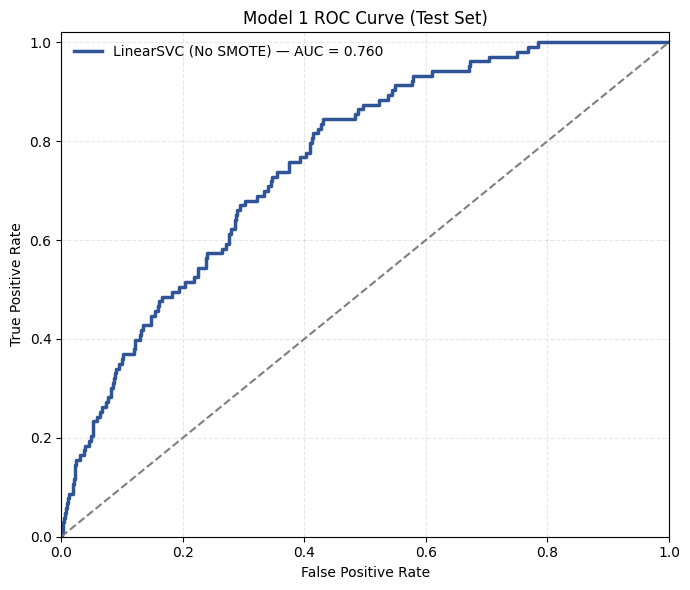

In [11]:
# Model 1 ROC curve 
roc_entry_m1 = next(item for item in roc_curve_data if item['Model'] == 'LinearSVC (No SMOTE)')
fpr_m1, tpr_m1, _ = roc_entry_m1['fpr_tpr']
roc_auc_m1 = roc_entry_m1['roc_auc']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(fpr_m1, tpr_m1, color='#2F5597', linewidth=2.5,
         label=f"LinearSVC (No SMOTE) — AUC = {roc_auc_m1:.3f}")
plt.plot([0, 1], [0, 1], '--', color='#7F7F7F', linewidth=1.5)
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 1 ROC Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


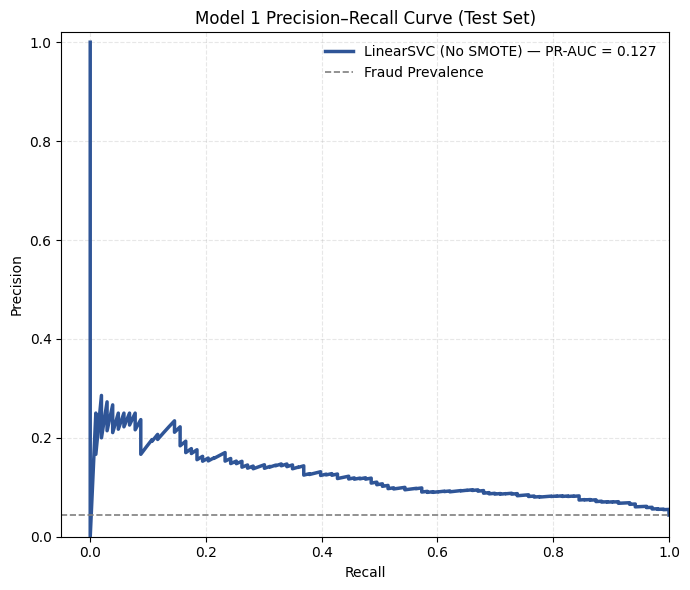

In [12]:
# Model 1 Precision–Recall curve
precision_m1, recall_m1, _ = model_artifacts['LinearSVC (No SMOTE)']['precision_recall']
pr_auc_m1 = next(item for item in model_results_summary if item['Model'] == 'LinearSVC (No SMOTE)')['PR-AUC']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(recall_m1, precision_m1, color='#2F5597', linewidth=2.5,
         label=f"LinearSVC (No SMOTE) — PR-AUC = {pr_auc_m1:.3f}")
plt.axhline(y=(y_test == 1).mean(), color='#7F7F7F', linestyle='--', linewidth=1.2,
            label='Fraud Prevalence')
plt.xlim(-0.05, 1)
plt.ylim(0, 1.02)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model 1 Precision–Recall Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


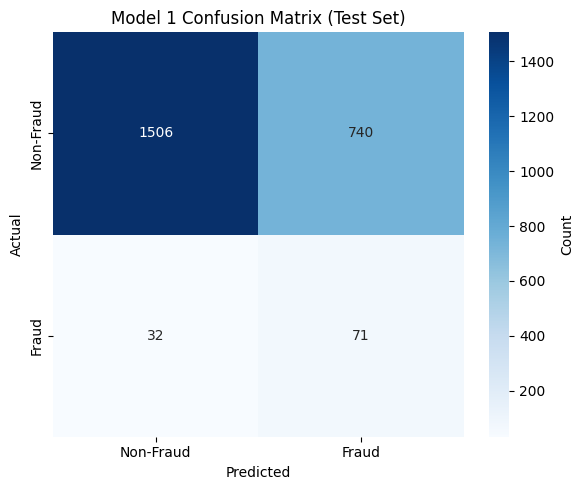

In [13]:
# Model 1 confusion matrix 
cm_m1 = model_artifacts['LinearSVC (No SMOTE)']['confusion']

plt.figure(figsize=(6, 5), facecolor='white')
sns.heatmap(cm_m1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title('Model 1 Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [14]:
# Model 1 performance summary 
model1_metrics = next(item for item in model_results_summary if item['Model'] == 'LinearSVC (No SMOTE)')
model1_table = pd.DataFrame([model1_metrics]).set_index('Model').reset_index(drop=True)

display(model1_table.style.format('{:.3f}'))


,ROC-AUC,PR-AUC,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,0.760,0.127,0.671,0.088,0.689,0.155


---

## Model 2: LinearSVC with SMOTE (Optuna Tuning)

Apply SMOTE to address class imbalance and evaluate performance against baseline model.

In [15]:
# Objective function with SMOTE resampling
def objective_smote(trial):
    C = trial.suggest_float('C', 0.1, 100, log=True)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1244)
    auc_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        # Apply SMOTE to training fold only
        X_tr_resampled, y_tr_resampled = apply_smote(X_tr, y_tr)
        
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_resampled)
        X_val_scaled = scaler.transform(X_val)

        svm = LinearSVC(
            C=C,
            class_weight=class_weight,
            random_state=1244,
            max_iter=2000,
            dual='auto' 
        )
        svm.fit(X_tr_scaled, y_tr_resampled)

        decision = svm.decision_function(X_val_scaled)
        auc_scores.append(roc_auc_score(y_val, decision))

    return np.mean(auc_scores)

print("Running Optuna optimization with SMOTE...")
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_smote = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1244)
)

study_smote.optimize(objective_smote, n_trials=30, show_progress_bar=True)

print("\nOptimization complete.")
print("Best Parameters:", study_smote.best_params)
print(f"Best CV ROC-AUC: {study_smote.best_value:.5f}")


Running Optuna optimization with SMOTE...


Best trial: 21. Best value: 0.699879: 100%|██████████| 30/30 [02:31<00:00,  5.05s/it]


Optimization complete.
Best Parameters: {'C': 0.10505119996159892, 'class_weight': None}
Best CV ROC-AUC: 0.69988


### Train Final Model with SMOTE

In [16]:
best_params_smote = study_smote.best_params

# Apply SMOTE to full training set
X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)

print(f"Original training set: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_resampled.shape[0]} samples")
print(f"Original class distribution:\n{y_train.value_counts()}")
print(f"\nAfter SMOTE class distribution:\n{pd.Series(y_train_resampled).value_counts()}")

# Standardize resampled features
scaler_smote = StandardScaler()
X_train_resampled_scaled = scaler_smote.fit_transform(X_train_resampled)

# Train final model with optimal hyperparameters
best_model_smote = LinearSVC(
    C=best_params_smote['C'],
    class_weight=best_params_smote['class_weight'],
    random_state=1244,
    max_iter=2000,
    dual='auto'
)

print("\nTraining final model with SMOTE...")
best_model_smote.fit(X_train_resampled_scaled, y_train_resampled)
print("Model training complete.")

Original training set: 9392 samples
After SMOTE: 17960 samples
Original class distribution:
target
0    8980
1     412
Name: count, dtype: int64

After SMOTE class distribution:
target
0    8980
1    8980
Name: count, dtype: int64

Training final model with SMOTE...
Model training complete.


### Evaluate Model 2 (with SMOTE) on Test Set

In [17]:
# Finalize Model 2 (LinearSVC with SMOTE) and prepare evaluation artifacts
X_test_scaled_smote = scaler_smote.transform(X_test)

model2_scores = best_model_smote.decision_function(X_test_scaled_smote)
model2_pred = best_model_smote.predict(X_test_scaled_smote)
model2_accuracy = accuracy_score(y_test, model2_pred)
model2_confusion = confusion_matrix(y_test, model2_pred)

report_m2 = classification_report(
    y_test,
    model2_pred,
    target_names=['Non-Fraud', 'Fraud'],
    output_dict=True,
    digits=4
)
roc_auc_m2 = roc_auc_score(y_test, model2_scores)
pr_auc_m2 = average_precision_score(y_test, model2_scores)

model2_metrics = {
    'Model': 'LinearSVC (SMOTE)',
    'ROC-AUC': roc_auc_m2,
    'PR-AUC': pr_auc_m2,
    'Accuracy': model2_accuracy,
    'Precision (Fraud)': report_m2['Fraud']['precision'],
    'Recall (Fraud)': report_m2['Fraud']['recall'],
    'F1-Score (Fraud)': report_m2['Fraud']['f1-score']
}

model_results_summary = [m for m in model_results_summary if m['Model'] != model2_metrics['Model']]
model_results_summary.append(model2_metrics)

model_artifacts['LinearSVC (SMOTE)'] = {
    'classifier': best_model_smote,
    'scaler': scaler_smote,
    'scores': model2_scores,
    'predictions': model2_pred,
    'confusion': model2_confusion,
    'precision_recall': precision_recall_curve(y_test, model2_scores)
}

roc_curve_data = [entry for entry in roc_curve_data if entry['Model'] != model2_metrics['Model']]
roc_curve_data.append({
    'Model': model2_metrics['Model'],
    'fpr_tpr': roc_curve(y_test, model2_scores),
    'roc_auc': roc_auc_m2
})

print('Model 2 artifacts prepared. Test ROC-AUC:', f"{roc_auc_m2:.3f}")


Model 2 artifacts prepared. Test ROC-AUC: 0.693


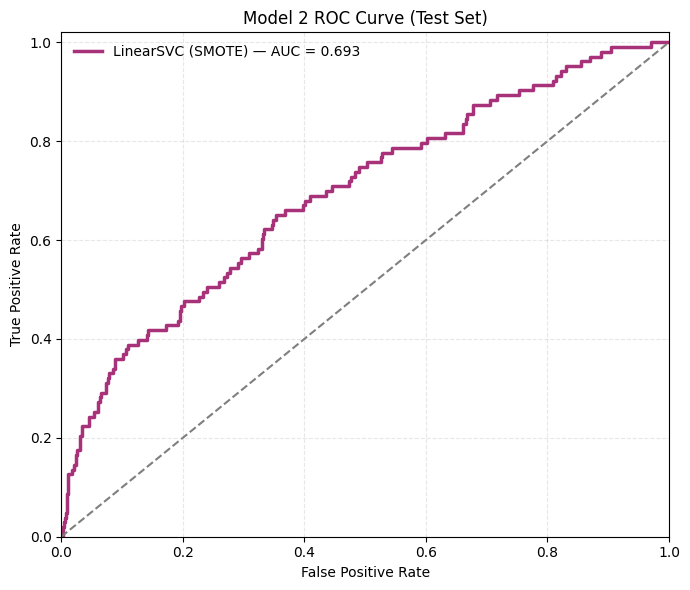

In [18]:
# Model 2 ROC curve 
roc_entry_m2 = next(item for item in roc_curve_data if item['Model'] == 'LinearSVC (SMOTE)')
fpr_m2, tpr_m2, _ = roc_entry_m2['fpr_tpr']
roc_auc_m2 = roc_entry_m2['roc_auc']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(fpr_m2, tpr_m2, color='#A83279', linewidth=2.5,
         label=f"LinearSVC (SMOTE) — AUC = {roc_auc_m2:.3f}")
plt.plot([0, 1], [0, 1], '--', color='#7F7F7F', linewidth=1.5)
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 2 ROC Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


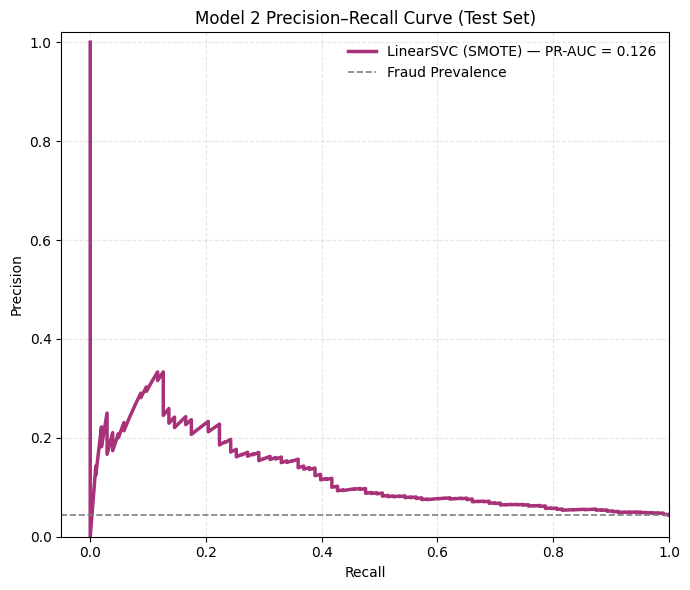

In [19]:
# Model 2 Precision–Recall curve 
precision_m2, recall_m2, _ = model_artifacts['LinearSVC (SMOTE)']['precision_recall']
pr_auc_m2 = next(item for item in model_results_summary if item['Model'] == 'LinearSVC (SMOTE)')['PR-AUC']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(recall_m2, precision_m2, color='#A83279', linewidth=2.5,
        label=f"LinearSVC (SMOTE) — PR-AUC = {pr_auc_m2:.3f}")
plt.axhline(y=(y_test == 1).mean(), color='#7F7F7F', linestyle='--', linewidth=1.2,
            label='Fraud Prevalence')
plt.xlim(-0.05, 1)
plt.ylim(0, 1.02)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model 2 Precision–Recall Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


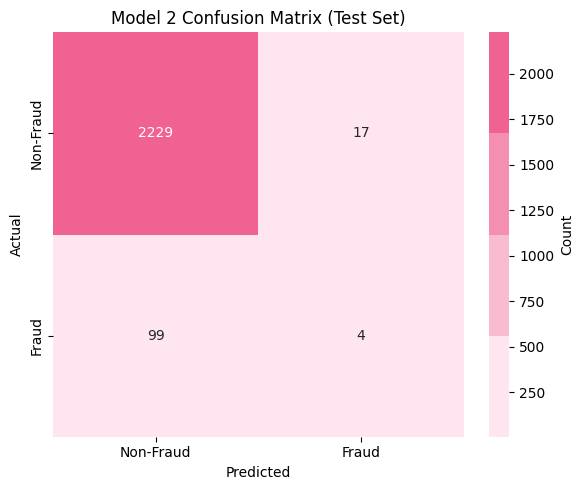

In [20]:
# Model 2 confusion matrix 
cm_m2 = model_artifacts['LinearSVC (SMOTE)']['confusion']

plt.figure(figsize=(6, 5), facecolor='white')
sns.heatmap(cm_m2,
            annot=True,
            fmt='d',
            cmap=sns.color_palette(['#FFE5F0', '#F8BBD0', '#F48FB1', '#F06292']),
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title('Model 2 Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [21]:
# Model 2 performance summary 
model2_metrics = next(item for item in model_results_summary if item['Model'] == 'LinearSVC (SMOTE)')
model2_table = pd.DataFrame([model2_metrics]).set_index('Model').reset_index(drop=True)

display(model2_table.style.format('{:.3f}'))


,ROC-AUC,PR-AUC,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,0.693,0.126,0.951,0.190,0.039,0.065


---

## Model 3: SVM with RBF Kernel (Optuna-Tuned)

**Reference:** Nagi, J., Yap, K. S., Tiong, S. K., Ahmed, S. K., & Mohamad, M. (2010). "Nontechnical Loss Detection for Metered Customers in Power Utility Using Support Vector Machines." *IEEE Transactions on Power Delivery*, 25(2), 1162-1171.

### Approach:
- **Features:** Uses same preprocessed data as Models 1 & 2 (includes consumption statistics, volatility, demand patterns from preprocessing)
- **Kernel:** RBF kernel for non-linear decision boundaries
- **Hyperparameter Optimization:** Optuna tuning for C
- **Class Imbalance:** Handled via class_weight parameter, as in the reference paper.
- **Evaluation:** ROC-AUC, PR-AUC, Precision, Recall, F1-score

In [22]:
# Using the same preprocessed data as Models 1 & 2 for consistency
print("="*70)
print("Model 3: RBF-SVM with Optuna Tuning")
print("="*70)
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features include consumption statistics, volatility, and monthly patterns")
print(f"from preprocessing pipeline")
print("="*70)

Model 3: RBF-SVM with Optuna Tuning
Training set: (9392, 39)
Test set: (2349, 39)
Features include consumption statistics, volatility, and monthly patterns
from preprocessing pipeline


### Hyperparameter Optimization with Optuna

RBF kernel requires careful tuning of C and gamma parameters. We use 5-fold CV with Optuna to find optimal values.

In [23]:
def objective_rbf(trial):
    """Objective function for RBF-SVM hyperparameter optimization."""
    C = trial.suggest_float('C', 0.1, 100, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1244)
    auc_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        # Standardize features
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        svm = SVC(
            kernel='rbf',
            C=C,
            gamma=gamma,
            class_weight=class_weight,
            random_state=1244
        )
        svm.fit(X_tr_scaled, y_tr)

        decision = svm.decision_function(X_val_scaled)
        auc_scores.append(roc_auc_score(y_val, decision))

    return np.mean(auc_scores)

print("Running Optuna optimization for RBF-SVM...")
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_rbf = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1244)
)

study_rbf.optimize(objective_rbf, n_trials=15, show_progress_bar=True) 

print("\nOptimization complete.")
print("Best Parameters:", study_rbf.best_params)
print(f"Best CV ROC-AUC: {study_rbf.best_value:.5f}")

Running Optuna optimization for RBF-SVM...


Best trial: 12. Best value: 0.742956: 100%|██████████| 15/15 [10:20<00:00, 41.40s/it]


Optimization complete.
Best Parameters: {'C': 0.10227300502432407, 'gamma': 'scale', 'class_weight': 'balanced'}
Best CV ROC-AUC: 0.74296


### Model Training: RBF Kernel SVM (Paper Configuration)

### Model Evaluation on Test Set

In [24]:
# Finalize Model 3 (RBF SVM) and prepare evaluation artifacts
best_params_rbf = study_rbf.best_params

scaler_rbf = StandardScaler()
X_train_rbf = scaler_rbf.fit_transform(X_train)
X_test_rbf = scaler_rbf.transform(X_test)

model3_clf = SVC(
    kernel='rbf',
    C=best_params_rbf['C'],
    gamma=best_params_rbf['gamma'],
    class_weight=best_params_rbf['class_weight'],
    random_state=1244
)
model3_clf.fit(X_train_rbf, y_train)

model3_scores = model3_clf.decision_function(X_test_rbf)
model3_pred = model3_clf.predict(X_test_rbf)
model3_accuracy = accuracy_score(y_test, model3_pred)
model3_confusion = confusion_matrix(y_test, model3_pred)

report_m3 = classification_report(
    y_test,
    model3_pred,
    target_names=['Non-Fraud', 'Fraud'],
    output_dict=True,
    digits=4
)
roc_auc_m3 = roc_auc_score(y_test, model3_scores)
pr_auc_m3 = average_precision_score(y_test, model3_scores)

model3_metrics = {
    'Model': 'RBF SVC (No SMOTE)',
    'ROC-AUC': roc_auc_m3,
    'PR-AUC': pr_auc_m3,
    'Accuracy': model3_accuracy,
    'Precision (Fraud)': report_m3['Fraud']['precision'],
    'Recall (Fraud)': report_m3['Fraud']['recall'],
    'F1-Score (Fraud)': report_m3['Fraud']['f1-score']
}

model_results_summary = [m for m in model_results_summary if m['Model'] != model3_metrics['Model']]
model_results_summary.append(model3_metrics)

model_artifacts['RBF SVC (No SMOTE)'] = {
    'classifier': model3_clf,
    'scaler': scaler_rbf,
    'scores': model3_scores,
    'predictions': model3_pred,
    'confusion': model3_confusion,
    'precision_recall': precision_recall_curve(y_test, model3_scores)
}

roc_curve_data = [entry for entry in roc_curve_data if entry['Model'] != model3_metrics['Model']]
roc_curve_data.append({
    'Model': model3_metrics['Model'],
    'fpr_tpr': roc_curve(y_test, model3_scores),
    'roc_auc': roc_auc_m3
})

print('Model 3 artifacts prepared. Test ROC-AUC:', f"{roc_auc_m3:.3f}")


Model 3 artifacts prepared. Test ROC-AUC: 0.773


### Evaluation Visualisations

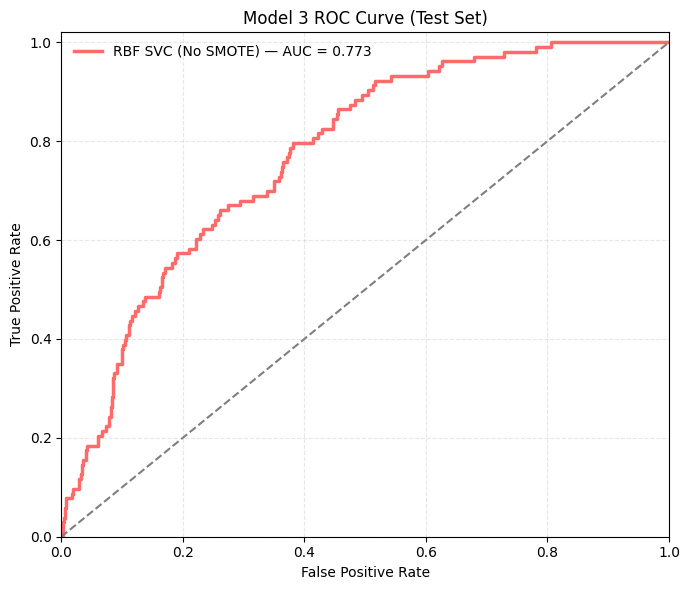

In [25]:
# Model 3 ROC curve 
roc_entry_m3 = next(item for item in roc_curve_data if item['Model'] == 'RBF SVC (No SMOTE)')
fpr_m3, tpr_m3, _ = roc_entry_m3['fpr_tpr']
roc_auc_m3 = roc_entry_m3['roc_auc']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(fpr_m3, tpr_m3, color='#FF6B6B', linewidth=2.5,
        label=f"RBF SVC (No SMOTE) — AUC = {roc_auc_m3:.3f}")
plt.plot([0, 1], [0, 1], '--', color='#7F7F7F', linewidth=1.5)
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 3 ROC Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


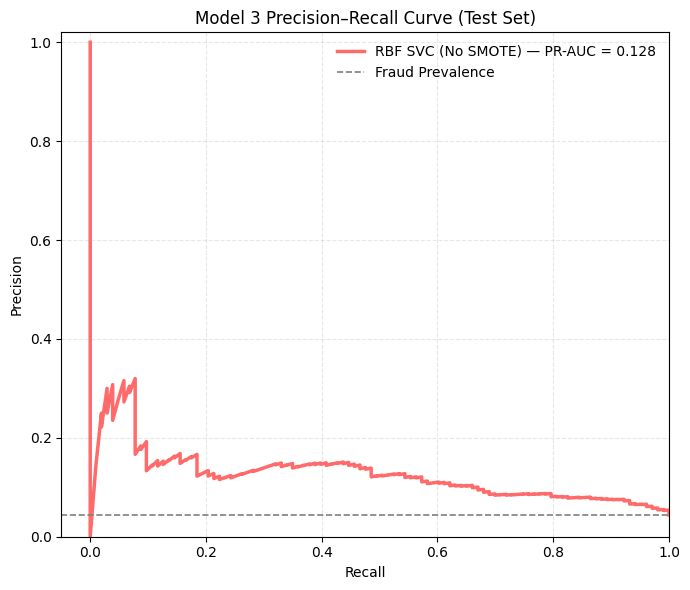

In [26]:
# Model 3 Precision–Recall curve
precision_m3, recall_m3, _ = model_artifacts['RBF SVC (No SMOTE)']['precision_recall']
pr_auc_m3 = next(item for item in model_results_summary if item['Model'] == 'RBF SVC (No SMOTE)')['PR-AUC']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(recall_m3, precision_m3, color='#FF6B6B', linewidth=2.5,
        label=f"RBF SVC (No SMOTE) — PR-AUC = {pr_auc_m3:.3f}")
plt.axhline(y=(y_test == 1).mean(), color='#7F7F7F', linestyle='--', linewidth=1.2,
            label='Fraud Prevalence')
plt.xlim(-0.05, 1)
plt.ylim(0, 1.02)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model 3 Precision–Recall Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


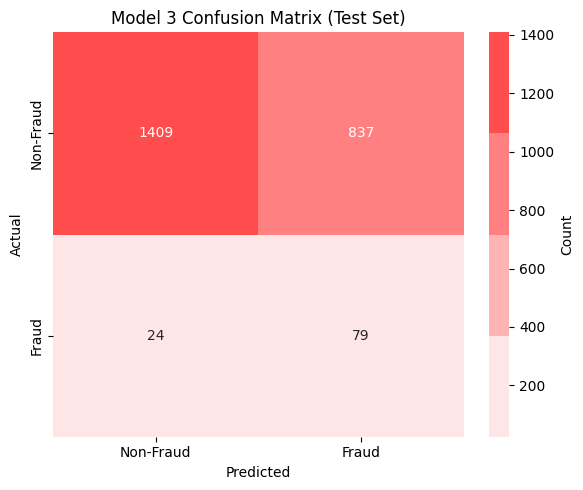

In [27]:
# Model 3 confusion matrix
cm_m3 = model_artifacts['RBF SVC (No SMOTE)']['confusion']

plt.figure(figsize=(6, 5), facecolor='white')
sns.heatmap(cm_m3,
            annot=True,
            fmt='d',
            cmap=sns.color_palette(['#FFE6E6', '#FFB3B3', '#FF8080', '#FF4D4D']),
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title('Model 3 Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Model Selected:
RBF SVC (No SMOTE), due to its relatively high scores in most metrics.
Moreover, it has the highest F1 score, which is favourable.

### Model 3 Performance Summary

In [28]:
# Model 3 performance summary 
model3_metrics = next(item for item in model_results_summary if item['Model'] == 'RBF SVC (No SMOTE)')
model3_table = pd.DataFrame([model3_metrics]).set_index('Model').reset_index(drop=True)

display(model3_table.style.format('{:.3f}'))


,ROC-AUC,PR-AUC,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,0.773,0.128,0.633,0.086,0.767,0.155


## Model 4: RBF SVC with SMOTE (Optuna-Tuned)

This variant augments the RBF SVM with an SMOTE-balanced training set before tuning. We test whether non-linear decision boundaries gain additional recall without sacrificing precision when minority samples are synthesised only within each training fold.

**Workflow:**
- Use Optuna to tune `C`, `gamma`, and `class_weight` while resampling the training folds with SMOTE.
- Retrain the best configuration on the full SMOTE-balanced training set and keep the test set untouched.
- Evaluate on the original test split with ROC-AUC, PR-AUC, precision, recall, and F1-score for the fraud class.
- Visualise ROC, precision–recall, and confusion matrices to compare directly against Models 1–3.

In [29]:
# Objective function and Optuna study for Model 4 (RBF SVC with SMOTE)
def objective_rbf_smote(trial):
    C = trial.suggest_float('C', 0.1, 100, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1244)
    auc_scores = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        X_tr_resampled, y_tr_resampled = apply_smote(X_tr, y_tr)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_resampled)
        X_val_scaled = scaler.transform(X_val)

        svm = SVC(
            kernel='rbf',
            C=C,
            gamma=gamma,
            class_weight=class_weight,
            random_state=1244
)
        
        svm.fit(X_tr_scaled, y_tr_resampled)

        decision = svm.decision_function(X_val_scaled)
        auc_scores.append(roc_auc_score(y_val, decision))

    return np.mean(auc_scores)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_rbf_smote = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=1244)
)

print('Running Optuna optimization for RBF SVC with SMOTE...')
study_rbf_smote.optimize(objective_rbf_smote, n_trials=15, show_progress_bar=True)

print('\nOptimization complete.')
print('Best Parameters:', study_rbf_smote.best_params)
print(f"Best CV ROC-AUC: {study_rbf_smote.best_value:.5f}")

Running Optuna optimization for RBF SVC with SMOTE...


Best trial: 12. Best value: 0.668889: 100%|██████████| 15/15 [13:10<00:00, 52.70s/it]


Optimization complete.
Best Parameters: {'C': 0.10224088555237, 'gamma': 'scale', 'class_weight': None}
Best CV ROC-AUC: 0.66889


In [30]:
# Train final RBF SVC with SMOTE and capture evaluation artifacts
best_params_rbf_smote = study_rbf_smote.best_params

X_train_rbf_smote, y_train_rbf_smote = apply_smote(X_train, y_train)
print(f"Original training set: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_rbf_smote.shape[0]} samples")

scaler_rbf_smote = StandardScaler()
X_train_rbf_smote_scaled = scaler_rbf_smote.fit_transform(X_train_rbf_smote)
X_test_rbf_smote_scaled = scaler_rbf_smote.transform(X_test)

model4_clf = SVC(
    kernel='rbf',
    C=best_params_rbf_smote['C'],
    gamma=best_params_rbf_smote['gamma'],
    class_weight=best_params_rbf_smote['class_weight'],
    random_state=1244
)
model4_clf.fit(X_train_rbf_smote_scaled, y_train_rbf_smote)

model4_scores = model4_clf.decision_function(X_test_rbf_smote_scaled)
model4_pred = model4_clf.predict(X_test_rbf_smote_scaled)
model4_accuracy = accuracy_score(y_test, model4_pred)
model4_confusion = confusion_matrix(y_test, model4_pred)

report_m4 = classification_report(
    y_test,
    model4_pred,
    target_names=['Non-Fraud', 'Fraud'],
    output_dict=True,
    digits=4
)
roc_auc_m4 = roc_auc_score(y_test, model4_scores)
pr_auc_m4 = average_precision_score(y_test, model4_scores)

model4_metrics = {
    'Model': 'RBF SVC (SMOTE)',
    'ROC-AUC': roc_auc_m4,
    'PR-AUC': pr_auc_m4,
    'Accuracy': model4_accuracy,
    'Precision (Fraud)': report_m4['Fraud']['precision'],
    'Recall (Fraud)': report_m4['Fraud']['recall'],
    'F1-Score (Fraud)': report_m4['Fraud']['f1-score']
}

# Refresh summaries to keep the notebook idempotent on re-run
model_results_summary = [m for m in model_results_summary if m['Model'] != model4_metrics['Model']]
model_results_summary.append(model4_metrics)

model_artifacts['RBF SVC (SMOTE)'] = {
    'classifier': model4_clf,
    'scaler': scaler_rbf_smote,
    'scores': model4_scores,
    'predictions': model4_pred,
    'confusion': model4_confusion,
    'precision_recall': precision_recall_curve(y_test, model4_scores)
}

roc_curve_data = [entry for entry in roc_curve_data if entry['Model'] != model4_metrics['Model']]
roc_curve_data.append({
    'Model': model4_metrics['Model'],
    'fpr_tpr': roc_curve(y_test, model4_scores),
    'roc_auc': roc_auc_m4
})

print('Model 4 artifacts prepared. Test ROC-AUC:', f"{roc_auc_m4:.3f}")

Original training set: 9392 samples
After SMOTE: 17960 samples
Model 4 artifacts prepared. Test ROC-AUC: 0.698


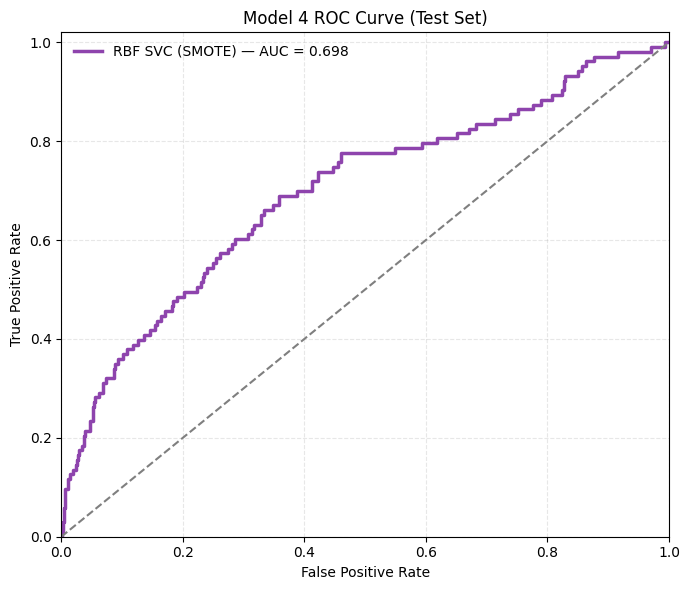

In [31]:
# Model 4 ROC curve 
roc_entry_m4 = next(item for item in roc_curve_data if item['Model'] == 'RBF SVC (SMOTE)')
fpr_m4, tpr_m4, _ = roc_entry_m4['fpr_tpr']
roc_auc_m4 = roc_entry_m4['roc_auc']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(fpr_m4, tpr_m4, color='#8E44AD', linewidth=2.5,
        label=f"RBF SVC (SMOTE) — AUC = {roc_auc_m4:.3f}")
plt.plot([0, 1], [0, 1], '--', color='#7F7F7F', linewidth=1.5)
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 4 ROC Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

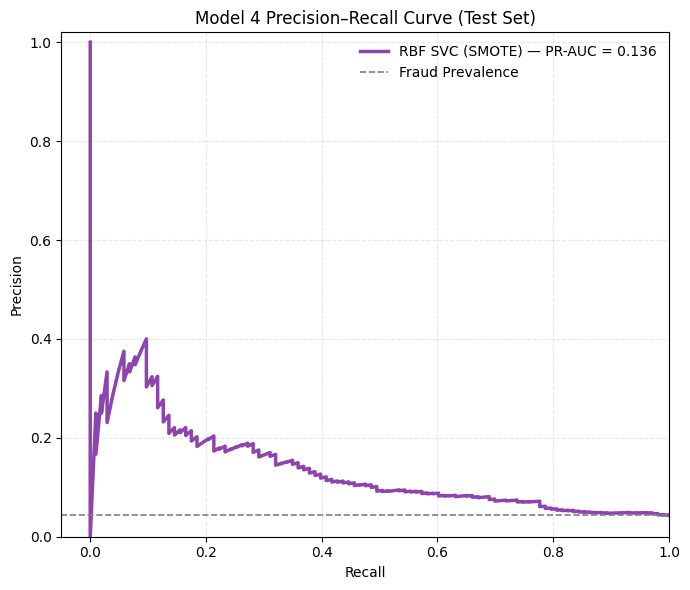

In [32]:
# Model 4 Precision–Recall curve
precision_m4, recall_m4, _ = model_artifacts['RBF SVC (SMOTE)']['precision_recall']
pr_auc_m4 = next(item for item in model_results_summary if item['Model'] == 'RBF SVC (SMOTE)')['PR-AUC']

plt.figure(figsize=(7, 6), facecolor='white')
plt.plot(recall_m4, precision_m4, color='#8E44AD', linewidth=2.5,
        label=f"RBF SVC (SMOTE) — PR-AUC = {pr_auc_m4:.3f}")
plt.axhline(y=(y_test == 1).mean(), color='#7F7F7F', linestyle='--', linewidth=1.2,
            label='Fraud Prevalence')
plt.xlim(-0.05, 1)
plt.ylim(0, 1.02)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Model 4 Precision–Recall Curve (Test Set)')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

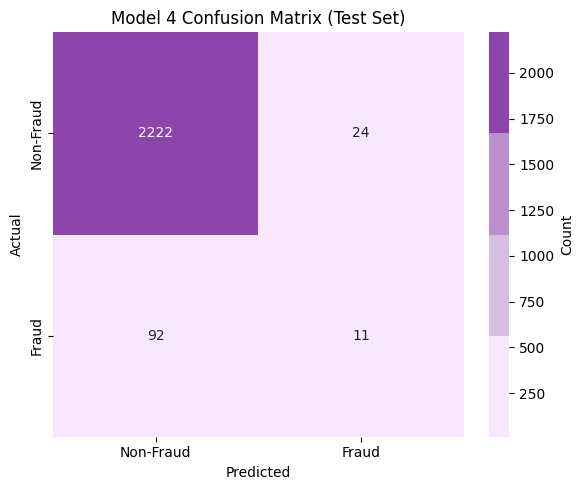

In [33]:
# Model 4 confusion matrix 
cm_m4 = model_artifacts['RBF SVC (SMOTE)']['confusion']

plt.figure(figsize=(6, 5), facecolor='white')
sns.heatmap(cm_m4,
            annot=True,
            fmt='d',
            cmap=sns.color_palette(['#F8E6FF', '#D7BDE2', '#BB8FCE', '#8E44AD']),
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title('Model 4 Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [34]:
# Model 4 performance summary 
model4_metrics = next(item for item in model_results_summary if item['Model'] == 'RBF SVC (SMOTE)')
model4_table = pd.DataFrame([model4_metrics]).set_index('Model').reset_index(drop=True)

display(model4_table.style.format('{:.3f}'))

,ROC-AUC,PR-AUC,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,0.698,0.136,0.951,0.314,0.107,0.159


---

## Cross-Model Comparison

The consolidated tables and plots below summarise how each tuned SVM variant performs on the held-out test set.

In [35]:
metrics_df = pd.DataFrame(model_results_summary)
metrics_order = ['Model', 'ROC-AUC', 'PR-AUC', 'Accuracy', 'Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)']
metrics_df = metrics_df[metrics_order].reset_index(drop=True)

styled_metrics = (
    metrics_df
    .style
    .format("{:.3f}", subset=metrics_df.select_dtypes(float).columns)
    .background_gradient(axis=0, cmap='YlGnBu')
)
display(styled_metrics)

,Model,ROC-AUC,PR-AUC,Accuracy,Precision (Fraud),Recall (Fraud),F1-Score (Fraud)
0,LinearSVC (No SMOTE),0.760,0.127,0.671,0.088,0.689,0.155
1,LinearSVC (SMOTE),0.693,0.126,0.951,0.190,0.039,0.065
2,RBF SVC (No SMOTE),0.773,0.128,0.633,0.086,0.767,0.155
3,RBF SVC (SMOTE),0.698,0.136,0.951,0.314,0.107,0.159


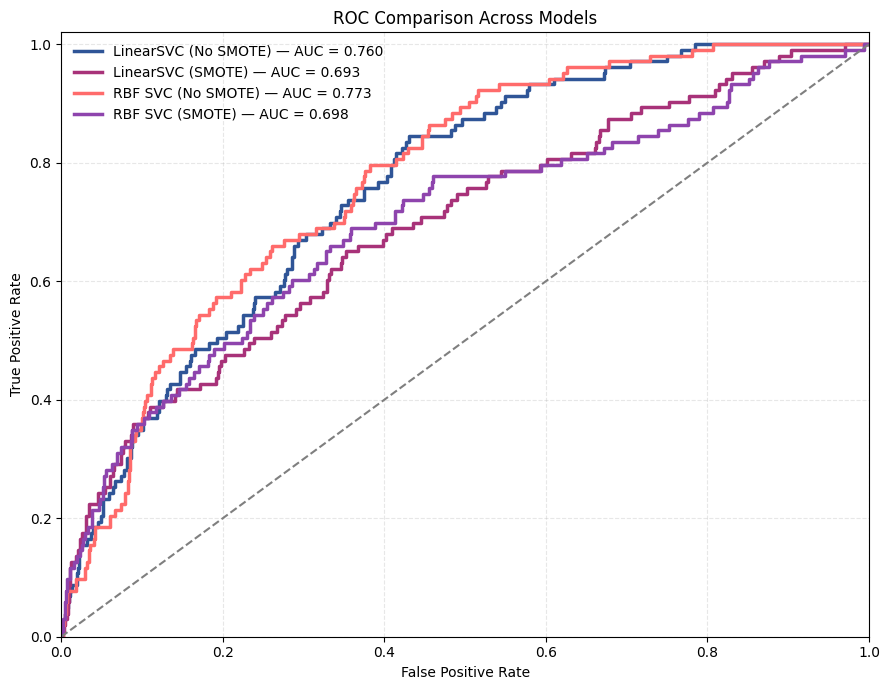

In [36]:
# Combined ROC curves across all models
palette = {
    'LinearSVC (No SMOTE)': '#2F5597',
    'LinearSVC (SMOTE)': '#A83279',
    'RBF SVC (No SMOTE)': '#FF6B6B',
    'RBF SVC (SMOTE)': '#8E44AD'
}

plt.figure(figsize=(9, 7), facecolor='white')
for entry in roc_curve_data:
    model_name = entry['Model']
    fpr, tpr, _ = entry['fpr_tpr']
    auc_score = entry['roc_auc']
    color = palette.get(model_name, '#555555')
    plt.plot(fpr, tpr,
             label=f"{model_name} — AUC = {auc_score:.3f}",
             linewidth=2.5,
             color=color)

plt.plot([0, 1], [0, 1], '--', color='#7F7F7F', linewidth=1.5)
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison Across Models')
plt.legend(frameon=False)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


Model Selection:

It is clear that the RBF SVM is superior. 

In fraud detection, failing to identify genuine fraudulent transactions (false negatives) is typically more costly than incorrectly flagging legitimate ones. Therefore, a high recall is crucial to capture as many fraudulent cases as possible and minimize overlooked fraud.  

Therefore RBF without SMOTE is chosen as the final model, as it has the highest (0.767) recall percentage.

In [37]:
# Persist final models for deployment comparison
joblib.dump(model3_clf, '../data/svm.pkl')

['../data/svm.pkl']